<a href="https://colab.research.google.com/github/JeanMichelDeveloper/Training/blob/main/Image_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Import necessary libraries
import torch
from torchvision import models, transforms
import requests
from PIL import Image
from io import BytesIO
import numpy
import matplotlib.pyplot as plt
import torch.optim as optimizers
from IPython import display

Load the model

In [12]:
#import model
vgg_model = models.vgg19(pretrained = True).features

#freeze parameters
for parameter in vgg_model.parameters():
  parameter.requires_grad_(False)

#move model to gpu if available
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_model.to(torch_device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Load images and reformat them for machine learning


In [13]:
#define loading and reformating function
def load_image(path_to_image, shape = None):

  #loading
  if "http" in path_to_image:
    response = requests.get(path_to_image)
    loaded_image = Image.open(BytesIO(response.content)).convert("RGB")

  else:
    loaded_image = Image.open(path_to_image).convert("RGB")

  #reformating
  maximum_size = 500

  if max(loaded_image.size) > maximum_size:
    size = maximum_size
  
  else:
    size = max(load_image.size)

  if shape is not None:
    size = shape
  
  image_transformations = transforms.Compose([
                          transforms.Resize(size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.495, 0.455, 0.405),
                                              (0.225, 0.220, 0.230))
                          ])
  
  loaded_image = image_transformations(loaded_image)[:3, :, :].unsqueeze(0)

  return loaded_image

Load original and style images

In [14]:
original_image = load_image("https://cdn.pixabay.com/photo/2015/09/19/20/43/person-947709_1280.jpg").to(torch_device)

style_image = load_image("https://cdn.pixabay.com/photo/2017/06/19/15/40/background-2419761_1280.jpg", shape = original_image.shape[-2:]).to(torch_device)

Display processed images

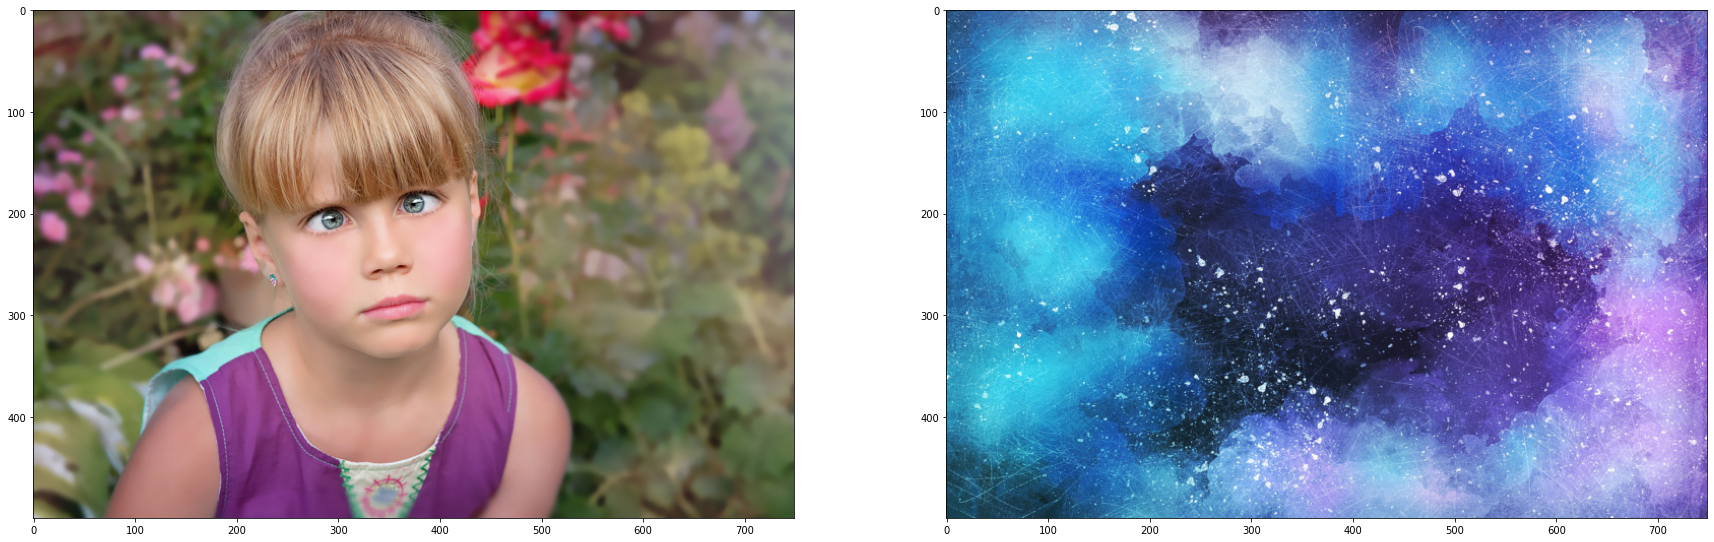

In [15]:
#function to return to image format
def display_image(tensor_image):
  #create a copy
  image_to_show = tensor_image.to("cpu").clone().detach()
  #squeeze
  image_to_show = image_to_show.numpy().squeeze()
  #return to original shape
  image_to_show = image_to_show.transpose(1, 2, 0)
  #unormalize
  image_to_show = image_to_show * numpy.array((0.225, 0.220, 0.230)) + numpy.array((0.495, 0.455, 0.405))
  #clip image
  image_to_show = image_to_show.clip(0, 1)

  return image_to_show

figure, (axis1, axis2) = plt.subplots(1, 2, figsize = (30, 20))

axis1.imshow(display_image(original_image))

axis2.imshow(display_image(style_image))

Extract image features

In [16]:
#define funtion to extract features from image
def extract_features(image, model, layers = None):
  if layers is None:
    layers = {"0": "conv1_1",
              "5": "conv2_1",
              "10": "conv3_1",
              "19": "conv4_1",
              "21": "conv4_2",
              "28": "conv5_1"}
  input = image

  features = {}

  for name, layer in model._modules.items():
    input = layer(input)

    if name in layers:
      features[layers[name]] = input
  
  return features

#extract features from original and style images
original_features = extract_features(original_image, vgg_model)

style_features = extract_features(style_image, vgg_model)

Determine Gram Matrix to represent image style

In [17]:
#define function to calculate Gram Matrix
def calculate_gram_matrix(tensor_image):
  batch_size, depth, height, width = tensor_image.size()

  tensor_image = tensor_image.view(depth, -1)

  gram_matrix = torch.mm(tensor_image, tensor_image.t())

  return gram_matrix

#calculate Gram Matrix for style image
style_gram_matrices = {layer: calculate_gram_matrix(style_features[layer]) for layer in style_features}

altered_image = original_image.clone().requires_grad_(True).to(torch_device)


Optimize the model

In [18]:
style_weights = {"conv1_1": 1.,
                 "conv2_1": 0.7,
                 "conv3_1": 0.4,
                 "conv4_1": 0.2,
                 "conv5_1": 0.1}

optimizer = optimizers.Adam([altered_image])

original_image_weight = 1

style_image_weight = 10000

Transfer style to image

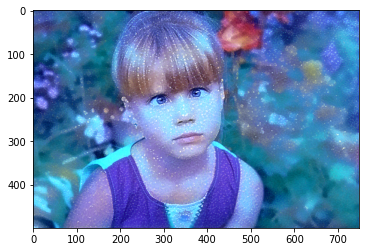

4762


In [ ]:
number_of_epochs = 5000

for index in range(0, number_of_epochs):
  altered_features = extract_features(altered_image, vgg_model)

  style_loss = 0

  original_image_loss = torch.mean((altered_features["conv4_2"] - original_features["conv4_2"]) ** 2)

  print(index)

  for layer in style_weights:
    altered_feature = altered_features[layer]

    altered_gram_matrix = calculate_gram_matrix(altered_feature)

    style_matrix = style_gram_matrices[layer]

    layer_style_loss = torch.mean((altered_gram_matrix - style_matrix) ** 2) * style_weights[layer]

    _, depth, height, width = altered_feature.shape

    style_loss += layer_style_loss / (depth * height * width)

  total_loss = original_image_loss * original_image_weight + style_loss * style_image_weight

  optimizer.zero_grad()

  total_loss.backward()

  optimizer.step()

  display.clear_output(wait = True)

  plt.imshow(display_image(altered_image))

  plt.show()